# Priors

A powerful aspect of a fully bayesian analysis approach is the possibility of explicitly stating any prior expectations about the parameter values based on previous knowledge. 

The most typical use of the IMAGINE employs Pipeline objects based on the Nested Sampling approach (e.g. Ultranest). This requires the priors to be specified as a *prior transform function*, that is: a mapping between uniformly distributed values to the actual distribution. The IMAGINE prior classes can handle this automatically and output either the *probability density function* (PDF) or the *prior transform function*, depending on the needs of the chosen sampler.

## Marginal prior distributions

We will first approach the case where we only have access independent prior information for each parameter (i.e. there is no prior information on correlation between parameters).  The `CustomPrior` class helps constructing an IMAGINE prior from either: a know prior PDF, or a previous sampling of the parameter space. 

### Prior from a sample

To illustrate this, we will first construct a sample associated with a hypothetical parameter. To keep things simple but still illustrative, we construct this combining a uniform distribution and a normal distribution.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import imagine as img
import corner, os
import scipy.stats

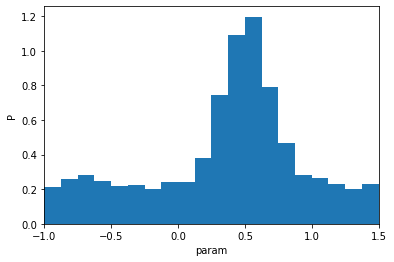

In [2]:
sample = np.concatenate([np.random.random_sample(2000),
                         np.random.normal(loc=0.6, scale=0.07, size=1500) ])
sample = sample*2.5-1
sample *= u.microgauss
plt.hist(sample.value, bins=20, density=True)
plt.ylabel('P'); plt.xlabel('param'); plt.xlim(-1,1.5);

This distribution could be the result of a previous inference exercise 
(e.g. *a previous run of the IMAGINE pipeline* using a different set of observables). 

From it, we can construct our prior using the `CustomPrior` class. 
Lets say that, for some reason, we are only interested in the interval 
$[-0.9,1.5]$ (say, for example, $p=-1$ is unphysical), this can be accounted for 
with the argument `interval`.

In [3]:
prior_param = img.priors.CustomPrior(samples=sample,
                                     xmin=-0.9*u.microgauss,
                                     xmax=1.5*u.microgauss)

At this point we can inspect the PDF to see what we have.

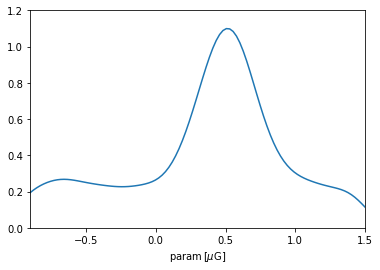

In [4]:
p = np.linspace(-0.9, 1.5, 100)*u.microgauss
plt.plot(p, prior_param.pdf(p))
plt.xlim(-0.9,1.5); plt.ylim(0,1.2); plt.xlabel(r'param$\,[\mu\rm G]$');

A cautionary note: the KDE used in intermediate calculation tends so smoothen the distribution and forces a slight decay close to the endpoints (reflecting the fact that a Gaussian kernel was employed). For most practical applications,
this is not a big problem: one can control the degree of smoothness through the argument `bw_method` while initializing `CustomPrior`, and the range close to endpoints are typically uninteresting. But it is recommended to always check the PDF of a prior generated from a set of samples.

### Prior from a known PDF

Alternatively, when one knows the analytic shape of given PDF, one can instead supply a function to `CustomPrior`. In this case, the shape of the original function is generally respected. For example:

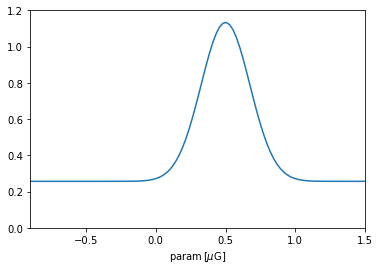

In [5]:
def example_pdf(y):
    x = y.to(u.microgauss).value # Handles units
    uniform_part = 1    
    sigma = 0.175; mu = 0.5
    gaussian_part = 1.5*( 1/(sigma * np.sqrt(2 * np.pi)) 
                         * np.exp( - (x - mu)**2 / (2 * sigma**2) ))
    return uniform_part + gaussian_part

prior_param = img.priors.CustomPrior(pdf_fun=example_pdf,
                                     xmin=-0.9*u.microgauss,
                                     xmax=1.5*u.microgauss)

plt.plot(p, prior_param.pdf(p))
plt.xlim(-0.9,1.5); plt.ylim(0,1.2); plt.xlabel(r'param$\,[\mu\rm G]$');

Once the prior object was constructed, the IMAGINE Pipeline object uses it as the mapping above described to sample new paramters. Let us illustrate this concretely and check whether the prior is working.

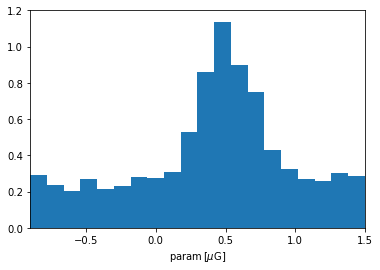

In [6]:
uniform_sample = np.random.random_sample(2000)
sampled_values = prior_param(uniform_sample)

plt.hist(sampled_values.value, bins=20, density=True)
plt.xlim(-0.9,1.5); plt.ylim(0,1.2); plt.xlabel(r'param$\,[\mu\rm G]$');

### Flat and Gaussian priors

Flat and Normal distributions are common prior choices when one is starting to tackle a particular problem. 
These are implemented by the classes `img.priors.FlatPrior` and `img.priors.GaussianPrior`, respectively. 

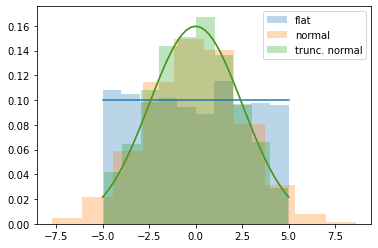

In [7]:
muG = u.microgauss # Convenience

flat_prior = img.priors.FlatPrior(xmin=-5*muG, xmax=5*muG)
gaussian_prior = img.priors.GaussianPrior(mu=0*muG, sigma=2.5*muG)
truncated_gaussian_prior = img.priors.GaussianPrior(mu=0*muG, sigma=2.5*muG, 
                                                    xmin=-5*muG, xmax=5*muG)

t = np.linspace(-5,5)*muG
plt.plot(t, flat_prior.pdf(t))
plt.plot(t, gaussian_prior.pdf(t))
plt.plot(t, truncated_gaussian_prior.pdf(t))
plt.gca().set_prop_cycle(None)
# Plots the distribution of values constructed using this prior
x = np.random.random_sample(2000)
plt.hist(flat_prior(x).value,
         density=True, alpha=0.3, label='flat')
plt.hist(gaussian_prior(x).value, 
         density=True, alpha=0.3, label='normal')
plt.hist(truncated_gaussian_prior(x).value, 
         density=True, alpha=0.3, label='trunc. normal')
plt.legend();

If using a `FlatPrior`, the range of the parameter *must be specified*. In the case of a `GaussianPrior`, if one specifies the limits a renormalized truncated distribution is used.

### Prior from scipy.stats distribution
We now demonstrate a helper class which allows to easily construct priors from any of the [scipy.stats distributions](https://docs.scipy.org/doc/scipy/reference/stats.html). Lets say that we would like to impose a [chi](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chi.html) prior distribution for a 
given parameter, we can achive this by using the `ScipyPrior` helper class.

In [8]:
chiPrior = img.priors.ScipyPrior(scipy.stats.chi, 3, loc=-10*muG, 
                                 scale=4*muG, xmin=-15*muG, xmax=5*muG)

The first argument of `img.priors.scipyPrior` is an instance of `scipy.stats.rv_continuous`, this is followed by any args required by the scipy distribution (in this specific case, `3` is the number of degrees of freedom in the chi-distribution). The keyword arguments loc and scale have the same meaning as in the `scipy.stats` case, and interval tells maximum and minimum parameter values that will be considered.

Let us check that this works, ploting the PDF and an histogram of parameter values sampled from the prior.

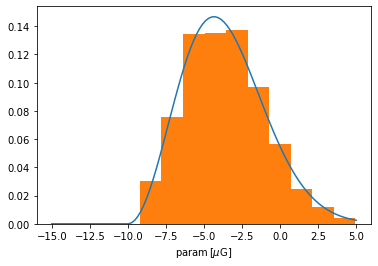

In [9]:
# Plots the PDF associated with this prior
t = np.linspace(*chiPrior.range,100)
plt.plot(t, chiPrior.pdf(t))
# Plots the distribution of values constructed using this prior
x = np.random.random_sample(2000)
plt.hist(chiPrior(x).value, density=True);
plt.xlabel(r'param$\,[\mu\rm G]$');

One might have noticed that the distribution above was truncated at the specified interval. As shown in the `GaussianPrior` case (above), IMAGINE also supports unbounded parameter ranges, this can be achieved by refraining from specifying the arguments `xmin` and `xmax` (or by setting them to `None`).

In [10]:
chi_prior = img.priors.ScipyPrior(scipy.stats.chi, 3, loc=-10*muG, unit=muG,
                                 scale=5*muG)
print('The range is now:', chiPrior.range)

The range is now: [-15.   5.] uG


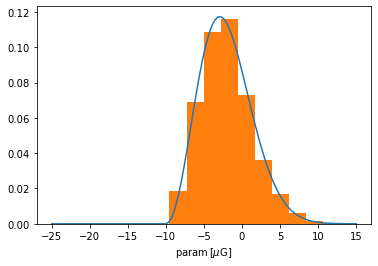

In [11]:
# Plots the PDF associated with this prior
t = np.linspace(-25,15,100)*muG
plt.plot(t, chi_prior.pdf(t))
# Plots the distribution of values constructed using this prior
x = np.random.random_sample(2000)
plt.hist(chi_prior(x).value, density=True);
plt.xlabel(r'param$\,[\mu\rm G]$');

## Correlated priors

It is also possible to set IMAGINE priors where the parameters are correlated. 
As previously mentioned, most common case where this is needed is when one starts from the results (samples) of a previous inference and wants now to include a different observable, which is where we begin.

### Correlated priors from samples

Given two or more samples supplied to `CustomPrior`, IMAGINE is able to estimate the correlation and use this information while running the Pipeline. To demonstrate this, we begin by artificially constructing samples of correlated priors using scipy's mutivariate normal distribution.

Pearson-r correlation: 0.7


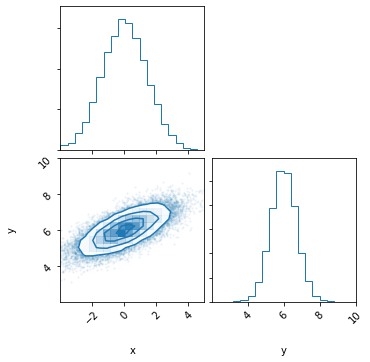

In [12]:
# Sets up the distribution object
distr = scipy.stats.multivariate_normal(mean=[0, 6],  
                                        cov=[[2.0, 0.7], 
                                             [0.7, 0.5]])
# Computes the samples and plots them
samples = distr.rvs(25000)
corner.corner(samples, range=[[-4,5],[2,10]], color='tab:blue', labels=['x','y']);
print('Pearson-r correlation: {0:.1f}'.format(scipy.stats.pearsonr(samples[:,0], samples[:,1])[0]))

Now, we initialize two `CustomPrior` instances with each of the correlated samples

In [13]:
prior_a = img.priors.CustomPrior(samples=samples[:,0]*muG)
prior_b = img.priors.CustomPrior(samples=samples[:,1]*muG)

For definiteness, let us prepare an imagine pipeline with a similar setup tutorial_one ("Basic pipeline...").

In [14]:
mockData = img.observables.TabularDataset({'test': [1,], 'err': [0.1]}, 
                                          name='test', err_col='err')
meas = img.observables.Measurements()
meas.append(mockData)
cov = img.observables.Covariances()
cov.append(mockData)

grid = img.fields.UniformGrid(box=[[0,2*np.pi]*u.kpc,
                                   [0,0]*u.kpc,
                                   [0,0]*u.kpc],
                              resolution=[2,1,1])

likelihood = img.likelihoods.EnsembleLikelihood(meas, cov)
simer = img.simulators.TestSimulator(meas)

ne_factory = img.fields.CosThermalElectronDensityFactory(grid=grid)
B_factory = img.fields.NaiveGaussianMagneticFieldFactory(grid=grid)

B_factory.active_parameters = ('a0','b0')
B_factory.priors = {'a0': prior_a, 'b0': prior_b}

In the last line, we associated the priors generated from the correlated samples to the parameters `a0` and `b0`.  There is one more step to actually account for the correlations in the samples: one need to provide the `Pipeline` with a prior correlations dictionary, explicitly saying that pairs of parameters may display correlations (it will look at the original samples and try to estimate the covariance from there):

In [15]:
prior_corr_dict = { ('a0', 'b0'): True}

run_dir = os.path.join(img.rc['temp_dir'], 'tutorial_priors')
pipeline = img.pipelines.UltranestPipeline(run_directory=run_dir,
                                           simulator=simer,
                                           factory_list=[ne_factory, B_factory], 
                                           likelihood=likelihood,
                                           prior_correlations=prior_corr_dict)

If we now run `pipeline`, the sampler will automatically draw the points from a correlated prior. 

Internally, IMAGINE is providing the chosen sampler with the method `prior_transform` which takes a vector of numbers in the [0, 1] interval (the "unit cube") and returns the parameter values of active parameters.

Let us use `prior_transform` to check how (and if) this working.

Pearson-r correlation: 0.7


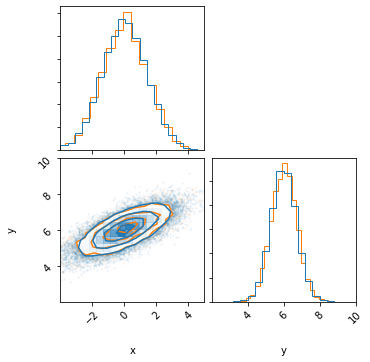

In [16]:
n = 5000
a, b = np.random.sample(n), np.random.sample(n)
X = pipeline.prior_transform(np.array([a,b]))
fig =corner.corner(X.T, color='tab:orange',hist_kwargs={'density':True})
corner.corner(samples, range=[[-4,5],[2,10]], color='tab:blue',
              labels=['x','y'], hist_kwargs={'density':True}, fig=fig)
print('Pearson-r correlation: {0:.1f}'.format(scipy.stats.pearsonr(X[0], X[1])[0]))

Where the dark blue curve is the new distribution.

### Setting prior correlations manually

In the situations where one is *not* constructing the priors from samples, it is still possible 
to set up prior correlations between parameters. To do this, we simply specify the correlation 
coefficient (instead of `True`) in the dictionary  supplied to the pipeline with the 
`prior_correlations` keyword. For example,

In [17]:
prior_corr_dict = { ('a0', 'b0'): -0.5}

pipeline_new = img.pipelines.UltranestPipeline(run_directory=run_dir,
                                               simulator=simer,
                                               factory_list=[ne_factory, B_factory], 
                                               likelihood=likelihood,
                                               prior_correlations=prior_corr_dict)

Pearson-r correlation: -0.5


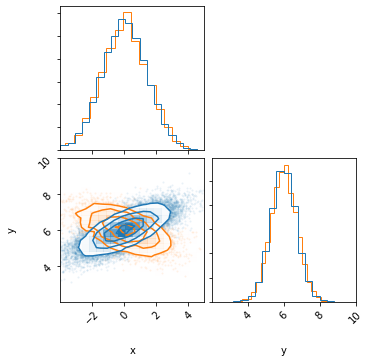

In [18]:
n = 5000
a, b = np.random.sample(n), np.random.sample(n)
X = pipeline_new.prior_transform(np.array([a,b]))
fig =corner.corner(X.T, color='tab:orange', scale_hist=True,hist_kwargs={'density':True})

corner.corner(samples, range=[[-4,5],[2,10]], color='tab:blue',
              labels=['x','y'], fig=fig,hist_kwargs={'density':True})
print('Pearson-r correlation: {0:.1f}'.format(scipy.stats.pearsonr(X[0], X[1])[0]))

This example illustrates how the same marginal distributions kept, but with different correlations.